# Solving incompressible flow with adaptive mixed finite elements in FEniCS

This Jupyter notebook shows how to solve the lid-driven cavity benchmark for incompressible flow by solving the Navier-Stokes equations using mixed finite elements in FEniCS with goal-oriented adaptive mesh refinement (AMR).

|Nomenclature||
|------------|-|
|$\mathbf{x}$| point in the spatial domain|
|$\mathbf{u} = \mathbf{u}(\mathbf{x})$| velocity vector field|
|$p = p(\mathbf{x})$| pressure field|
|$\mu$| constant dynamic viscosity of the fluid|
|$\Omega$| spatial domain |
|$\mathbf{w} = \begin{pmatrix} \mathbf{u} \\ p \end{pmatrix}$| system solution|
|$\mathbf{W}$| mixed finite element function space |
|$\boldsymbol{\psi} = \begin{pmatrix} \boldsymbol{\psi}_u \\ \psi_p \end{pmatrix}$| mixed finite element basis functions|
|$\Omega_h$| discrete spatial domain, i.e. the mesh |
|$M$| goal functional |
|$\epsilon_M$| error tolerance for goal-oriented AMR |

## The Navier-stokes equations for incompressible flow

The steady incompressible Navier-Stokes equations can be written as

\begin{align*} 
    \left( \mathbf{u}\cdot\nabla \right)\mathbf{u} + \nabla p - 2\mu \nabla \cdot \mathbf{D}(\mathbf{u}) &= 0 \quad \\
    \nabla \cdot \mathbf{u} &= 0 \quad  \\
\end{align*}

where  $\mathbf{D}(\mathbf{u}) = \mathrm{sym}(\mathbf{u}) = \frac{1}{2}\left(\nabla \mathbf{u} +  \left( \nabla \mathbf{u} \right)^{\mathrm{T}} \right)$ is the Newtonian fluid's rate of strain tensor. [3]

## Python packages

Import the Python packages for use in this notebook.

We need the finite element method library FEniCS.

In [1]:
import fenics

|Note|
|----|
| This Jupyter notebook server is using FEniCS 2017.2.0 from ppa:fenics-packages/fenics, installed via `apt` on Ubuntu 16.04.|

FEniCS has convenient plotting features that don't require us to import `matplotlib`; but using `matplotlib` directly will allow us to annotate the plots.

In [2]:
import matplotlib

Tell this notebook to embed graphical outputs from `matplotlib`, includings those made by `fenics.plot`.

In [3]:
%matplotlib inline

## Coarse mesh

Now, define a coarse mesh on the unit square.

In [4]:
N = 4

mesh = fenics.UnitSquareMesh(N, N)

Let's look at the mesh.

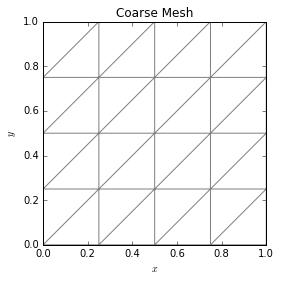

In [5]:
fenics.plot(mesh)

matplotlib.pyplot.title("Coarse Mesh")

matplotlib.pyplot.xlabel("$x$")

matplotlib.pyplot.ylabel("$y$")

## Mixed finite element function space, test functions, and solution functions

Make the Taylor-Hood (i.e. P2P1) mixed finite element, which has been shown to be stable for the incompressible Navier-Stokes equations [3].

In [6]:
P2 = fenics.VectorElement('P', mesh.ufl_cell(), 2)

P1 = fenics.FiniteElement('P', mesh.ufl_cell(), 1)

P2P1 = fenics.MixedElement([P2, P1])

|Note|
|----|
|`fenics.FiniteElement` requires the `mesh.ufl_cell()` argument to determine some aspects of the domain (e.g. that the spatial domain is two-dimensional).|

Make the mixed finite element function space $\mathbf{W}$, which enumerates the finite element basis functions on each cell of the mesh.

In [7]:
W = fenics.FunctionSpace(mesh, P2P1)

Make the test functions $\boldsymbol{\psi}_u$ and $\psi_p$.

In [8]:
psi_u, psi_p = fenics.TestFunctions(W)

Make the system solution function $\mathbf{w} \in \mathbf{W}$ and obtain references to its components $\mathbf{u}$ and $p$.

In [9]:
w = fenics.Function(W)

u, p = fenics.split(w)

## Benchmark parameters

Set a constant dynamic viscosity $\mu$. Here we choose $\mu = 0.01$ corresponding to a Reynolds Number of $\mathrm{Re} = 100$. We define a `fenics.Constant` for use in the variational form so that FEniCS can more efficiently compile the finite element code.

In [10]:
dynamic_viscosity = 0.01

mu = fenics.Constant(dynamic_viscosity)

Now we have everything we need to define the nonlinear variational form. First let's define aliases for some of the build-in math functions from `fenics` to improve readability. We also define an alias for the integration measure $d\mathbf{x}$.

## Nonlinear variational form

We can write the nonlinear system of equations as

\begin{align*}
\mathbf{F}(\mathbf{w}) = \mathbf{0}
\end{align*}

To obtain the finite element weak form, we follow the standard Ritz-Galerkin method extended for mixed finite elements [1]. Therefore, we multiply the system  *from the left* by test functions $\boldsymbol{\psi}$ from the mixed finite element function space $\mathbf{W}$ and integrate over the spatial domain $\Omega$. This gives us the variational problem: Find $\mathbf{w} \in \mathbf{W}$ such that

\begin{align*}
    \mathcal{F}(\boldsymbol{\psi};\mathbf{w}) = \int_\Omega 
    \boldsymbol{\psi}^\mathrm{T} \mathbf{F}(\mathbf{w}) 
    d\mathbf{x} = 0 \quad \forall \boldsymbol{\psi} \in \mathbf{W}
\end{align*}

 Integrating $\mathcal{F}$ by parts yields

\begin{align*}
    \mathcal{F}(\boldsymbol{\psi};\mathbf{w}) = (\boldsymbol{\psi}_u, \nabla\mathbf{u}\cdot\mathbf{u}) -(\nabla\cdot\boldsymbol{\psi}_u,p) + 2\mu(\mathbf{D}(\boldsymbol{\psi}_u),\mathbf{D}(\mathbf{u})) \\
    -(\psi_p,\nabla\cdot\mathbf{u})
\end{align*}

|Note| 
|----|
|We denote integrating inner products over the domain as $(v,u) = \int_\Omega v u d \mathbf{x}$ or $(\mathbf{v},\mathbf{u}) = \int_\Omega \mathbf{v} \cdot \mathbf{u} d \mathbf{x}$.|

Define the nonlinear variational form $\mathcal{F}$.

In [11]:
inner, dot, grad, div, sym = \
    fenics.inner, fenics.dot, fenics.grad, fenics.div, fenics.sym

momentum = dot(psi_u, dot(grad(u), u)) - div(psi_u)*p \
    + 2.*mu*inner(sym(grad(psi_u)), sym(grad(u)))

mass = -psi_p*div(u)
        
F = (momentum + mass)*fenics.dx

## Linearization

Notice that $\mathcal{F}$ is a *nonlinear* variational form. FEniCS will solve the nonlinear problem using Newton's method. This requires computing the Jacobian (formally the Gâteaux derivative) of the nonlinear variational form, yielding a a sequence of linearized problems whose solutions may converge to approximate the nonlinear solution.

We could manually define the Jacobian; but thankfully FEniCS can do this for us.

In [12]:
JF = fenics.derivative(F, w, fenics.TrialFunction(W))

|Note|
|----|
|When solving linear variational problems in FEniCS, one defines the linear variational form using `fenics.TrialFunction` instead of `fenics.Function` (while both approaches will need `fenics.TestFunction`). When solving nonlinear variational problems with FEniCS, we only need `fenics.TrialFunction` to define the linearized problem, since it is the linearized problem which will be assembled into a linear system and solved.|

## Boundary conditions

We need boundary conditions before we can define a nonlinear variational *problem* (i.e. in this case a boundary value problem).

For the lid-driven cavity, we physically consider *no slip* velocity boundary conditions for all boundaries. These manifest as homogeneous Dirichlet boundary conditions on the fixed walls, but as a non-homogeneous Dirichlet boundary condition on the lid. Because the problem's geometry is simple, we can identify the boundaries with the following piece-wise function.

\begin{align*}
    \mathbf{u}(\mathbf{x}) &= 
    \begin{cases}
    \begin{pmatrix} 1 \\ 0 \end{pmatrix}, && x_1 = 1 \\
    \begin{pmatrix} 0 \\ 0 \end{pmatrix}, && x_0 = 0 \hspace{2mm} \mathrm{or} \hspace{2mm} x_0 = 1 \hspace{2mm} \mathrm{or} \hspace{2mm} x_1 = 0
    \end{cases}
\end{align*}

In [13]:
lid_velocity = (1., 0.)

lid_location = "near(x[1],  1.)"

fixed_wall_velocity = (0., 0.)

fixed_wall_locations = "near(x[0], 0.) | near(x[0], 1.) | near(x[1], 0.)"

Define the boundary conditions on the velocity subspace.

In [14]:
V = W.sub(0)

boundary_conditions = [
    fenics.DirichletBC(V, lid_velocity, lid_location),
    fenics.DirichletBC(V, fixed_wall_velocity, fixed_wall_locations)]

## Nonlinear variational problem

Now we have everything we need to define the variational problem.

In [15]:
problem = fenics.NonlinearVariationalProblem(F, w, boundary_conditions, JF)

## Goal-oriented adaptive mesh refinement (AMR)

We wish to solve the problem with adaptive mesh refinement (AMR). For this it helps to explain that we have already defined the *discrete* nonlinear variational problem using FEniCS: Find $\mathbf{w}_h \in \mathbf{W}_h \subset \mathbf{W}(\Omega)$ such that

\begin{align*}
    \mathcal{F}(\boldsymbol{\psi}_h;\mathbf{w}_h) = 0 \quad \forall \boldsymbol{\psi}_h \in \mathbf{W}_h \subset \mathbf{W}
\end{align*}

Given this, goal-oriented AMR poses the problem: Find $\mathbf{W}_h \subset \mathbf{W}(\Omega)$ and $\mathbf{w}_h \in \mathbf{W}_h$ such that

\begin{align*}
    \left| M(\mathbf{w}) - M(\mathbf{w}_h) \right| < \epsilon_M
\end{align*}

where $M$ is some goal functional of the solution which we integrate over the domain, and where $\epsilon_M$ is a prescribed tolerance. Note that since we do not know the exact solution $\mathbf{w}$, this method requires an error estimator. This is detailed in [2]. For our purposes, we only need to define $M$ and $\epsilon_M$.

We choose a goal involving the horizontal velocity.

\begin{align*}
    M = \int_\Omega u_0^2 d\mathbf{x}
\end{align*}

In [16]:
M = u[0]**2*fenics.dx

Let's set the tolerance somewhat arbitrarily. For real problems of scientific or engineering interest, one might have accuracy requirements which could help drive this decision.

In [17]:
epsilon_M = 1.e-4

## The benchmark solution

Finally we instantiate the adaptive solver with our problem and goal

In [18]:
solver = fenics.AdaptiveNonlinearVariationalSolver(problem, M)

and solve the problem to the prescribed tolerance.

In [19]:
solver.solve(epsilon_M)

|Note|
|----|
|`solver.solve` will modify the solution `w`, which means that `u` and `p` will also be modified.|

To post-process the solution, we must take an extra step calling `fenics.Function.leaf_node()` to access the solution on the refined mesh.

In [20]:
u, p = fenics.split(w.leaf_node())

Now plot the velocity vector field

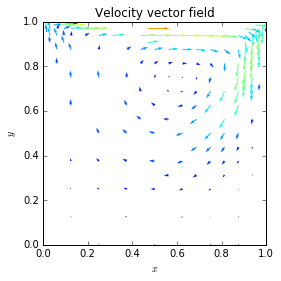

In [21]:
fenics.plot(u)

matplotlib.pyplot.title("Velocity vector field")

matplotlib.pyplot.xlabel("$x$")

matplotlib.pyplot.ylabel("$y$")

and also plot the adapted mesh.

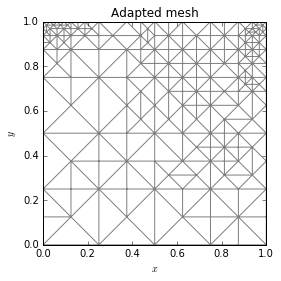

In [22]:
fenics.plot(mesh.leaf_node())

matplotlib.pyplot.title("Adapted mesh")

matplotlib.pyplot.xlabel("$x$")

matplotlib.pyplot.ylabel("$y$")

## References
[1] F Brezzi and M Fortin. **Mixed and hybrid finite element methods**, volume 15.
*Springer Science & Business Media*, 1991.

[2] W Bangerth and R Rannacher. **Adaptive Finite Element Methods for Differential Equations**. *Springer Science & Business Media*, 2003.

[3] J Donea and A Huerta. **Finite element methods for flow problems.** *John Wiley &
Sons*, 2003. 

[4] A Logg, KA Mardal, and GN Wells. **Automated Solution of Differential Equations by the Finite Element Method**, *Springer*, 2012.